# 문서 유사도 (Document Similarity)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os, glob

path = 'C:\\encore_sk-net-fam_9\\lecture_source\\nlp\\01_text_analysis\\data\\OpinosisDataset1.0\\topics'
all_files = glob.glob(os.path.join(path, '*.data'))

filename_list = []
opinions_list = []

for file_ in all_files:
    df = pd.read_table(file_, header=None, index_col=None, encoding='latin1')
    # display(df)

    # 파일명
    filename = file_.split('\\')[-1]
    filename = filename.split('.')[0]
    filename_list.append(filename)

    # 의견 내용
    opinions = df.to_string(index=False, header=False)
    opinions_list.append(opinions)

document_df = pd.DataFrame({
    'filename': filename_list,
    'opinions': opinions_list
})

document_df

In [ ]:
import string
import nltk
from nltk.stem import WordNetLemmatizer

def lemmatize(text):
    # 소문자 변환
    text = text.lower()

    # 특수문자 변환 (제거)
    punc_rem_dict = dict((ord(ch), None) for ch in string.punctuation)
    text = text.translate(punc_rem_dict)

    # 토큰화
    tokens = nltk.word_tokenize(text)

    # 어근 분리
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token, pos='v') for token in tokens]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    tokenizer=lemmatize,
    stop_words='english',
    ngram_range=(1, 2),
    max_df=0.85,
    min_df=0.05
)
opinions_vecs = tfidf_vectorizer.fit_transform(document_df['opinions'])

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, max_iter=5000, random_state=0)
document_df['cluster'] = kmeans.fit_predict(opinions_vecs)
document_df

In [ ]:
hotel_index = document_df[document_df['cluster'] == 1].index
print(hotel_index.shape)
print(hotel_index)

base_index = 1
document_df.iloc[base_index]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# print(opinions_vecs[base_index].shape, opinions_vecs.shape)
opinions_sim = cosine_similarity(opinions_vecs[base_index], opinions_vecs)
opinions_sim

In [ ]:
opinion_sorted_idx = opinions_sim.argsort()[:, ::-1] # 내림차순 정렬 (유사도 높은순)
opinion_sorted_idx = opinion_sorted_idx[:, 1:]       # 자기자신 제외
opinion_sorted_idx = opinion_sorted_idx.reshape(-1)  # 1차원으로 변형

result_df = document_df.iloc[opinion_sorted_idx][['filename', 'cluster']]
opinions_sim = opinions_sim.reshape(-1)
result_df['similarity'] = opinions_sim[opinion_sorted_idx]
result_df

In [ ]:
sns.barplot(x='similarity', y='filename', data=result_df.iloc[:20], hue='filename')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_14924\560940297.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_sim_df['similarity'] = target_sim_val


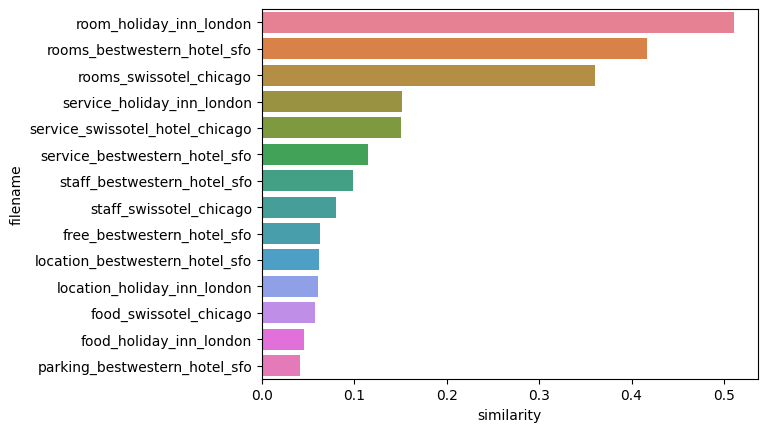

In [14]:
# 호텔관련 리뷰 추출 (A)
hotel_idx = document_df[document_df['cluster'] == 1].index
# print(hotel_idx)
 
# A에서 기준이 될 문서로 0번째 문서 지정
base_idx = hotel_idx[0]
# document_df.iloc[base_idx]

# 호텔관련 리뷰 중 유사도 높은 순으로 정렬
target_sim = cosine_similarity(opinions_vecs[base_idx], opinions_vecs[hotel_idx])
target_sim_sorted_idx = target_sim.argsort()[:, ::-1]
target_sim_sorted_idx = target_sim_sorted_idx[:, 1:]

hotel_sorted_idx = hotel_idx[target_sim_sorted_idx.reshape(-1)]

target_sim_val = np.sort(target_sim.reshape(-1))[::-1]
target_sim_val = target_sim_val[1:]

hotel_sim_df = document_df.iloc[hotel_sorted_idx]
hotel_sim_df['similarity'] = target_sim_val

# 시각화
sns.barplot(x='similarity', y='filename', data=hotel_sim_df, hue='filename')
plt.show()